In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
from netCDF4 import Dataset, date2num, num2date
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

%matplotlib inline

2024-09-05 15:53:15.732982: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-05 15:53:15.764854: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
allDS = xr.open_dataset('goodData_TRMMwithTAO.nc')
#ds.close()

In [3]:
allDS

<xarray.Dataset> Size: 107MB
Dimensions:                          (count: 49344, TAO_TIME_INDEX: 13)
Coordinates:
    LATITUDE                         (count) float64 395kB ...
    LONGITUDE                        (count) float64 395kB ...
  * count                            (count) int64 395kB 0 1 2 ... 65519 65520
  * TAO_TIME_INDEX                   (TAO_TIME_INDEX) int64 104B -6 -5 ... 5 6
Data variables: (12/164)
    Wind Direction (TAO)             (count, TAO_TIME_INDEX) float32 3MB ...
    WDIR_QC                          (count, TAO_TIME_INDEX) float32 3MB ...
    WDIR_DM                          (count, TAO_TIME_INDEX) |S1 641kB ...
    Wind Speed (TAO)                 (count, TAO_TIME_INDEX) float32 3MB ...
    WSPD_QC                          (count, TAO_TIME_INDEX) float32 3MB ...
    WSPD_DM                          (count, TAO_TIME_INDEX) |S1 641kB ...
    ...                               ...
    std. dev. sinWDIR 110min         (count) float64 395kB ...
    TAO_TIME                         (count, TAO_TIME_INDEX) datetime64[ns] 5MB ...
    Deployment index                 (count) int64 395kB ...
    nearSurfRain                     (count) float64 395kB ...
    e_SurfRain                       (count) float64 395kB ...
    TRMM_TIME                        (count) datetime64[ns] 395kB ...

In [4]:
allDS = allDS.sel(TAO_TIME_INDEX = 0)

In [5]:
mask = np.zeros(len(allDS['count'].to_numpy()), dtype=bool)
for var in ['nearSurfRain'] :#, 'e_SurfRain']:
    mask += np.isnan(allDS[var].to_numpy())
    mask += allDS[var] < 0

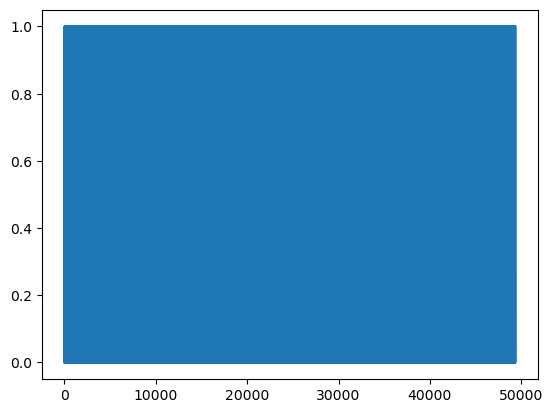

In [6]:
mask = ~mask
mask = mask.to_numpy()
plt.plot(mask)

In [7]:
mask.shape

(49344,)

In [8]:
mask

array([False, False, False, ..., False,  True,  True])

In [9]:
allDS = allDS.isel(count=np.nonzero(mask)[0])

In [10]:
allDS_pdFrame = allDS.to_dataframe()

In [11]:
data = allDS_pdFrame #.~mask]

In [12]:
data

,Wind Direction (TAO),WDIR_QC,WDIR_DM,Wind Speed (TAO),WSPD_QC,WSPD_DM,Zonal Wind Speed (TAO),Meridional Wind Speed (TAO),Sea Surface Temperature (TAO),SST_QC,...,mean sinWDIR 110min,std. dev. sinWDIR 110min,LATITUDE,LONGITUDE,TAO_TIME,Deployment index,nearSurfRain,e_SurfRain,TRMM_TIME,TAO_TIME_INDEX
count,,,,,,,,,,,,,,,,,,,,,
18,319.500000,2.0,b'D',4.93,2.0,b'D',-3.20,3.75,25.510000,2.0,...,0.715291,0.042456,-8.0,265.0,2000-02-03 22:30:00,0,0.0,0.0,2000-02-03 22:39:37.000491,0
19,323.700012,2.0,b'D',4.46,2.0,b'D',-2.64,3.59,25.507000,2.0,...,0.715291,0.042456,-8.0,265.0,2000-02-03 22:40:00,0,0.0,0.0,2000-02-03 22:39:38.000090,0
31,325.299988,2.0,b'D',4.31,2.0,b'D',-2.45,3.54,26.724001,2.0,...,0.816390,0.038874,-8.0,265.0,2000-02-24 11:50:00,0,0.0,0.0,2000-02-24 11:45:52.000378,0
55,358.899994,2.0,b'D',4.70,2.0,b'D',-0.09,4.70,26.693001,2.0,...,0.997843,0.002157,-8.0,265.0,2000-04-02 16:00:00,0,0.0,0.0,2000-04-02 15:57:53.000005,0
80,314.399994,2.0,b'D',8.67,2.0,b'D',-6.19,6.07,26.445999,2.0,...,0.689848,0.033053,-8.0,265.0,2000-05-12 19:20:00,1,0.0,0.0,2000-05-12 19:22:20.000281,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65500,244.600006,2.0,b'D',8.48,2.0,b'D',-7.66,-3.64,27.434999,2.0,...,-0.472002,0.041908,9.0,220.0,2006-12-03 14:39:59,10,0.0,0.0,2006-12-03 14:39:06.000648,0
65504,220.500000,2.0,b'D',11.34,2.0,b'D',-7.36,-8.63,27.636000,2.0,...,-0.693176,0.131778,9.0,220.0,2006-12-10 11:30:00,10,0.0,0.0,2006-12-10 11:26:41.000304,0
65516,236.199997,2.0,b'D',11.05,2.0,b'D',-9.18,-6.15,27.236000,2.0,...,-0.561130,0.035783,9.0,220.0,2006-12-25 17:20:00,10,0.0,0.0,2006-12-25 17:16:26.000874,0


In [13]:
data['Sea Surface Temperature (TAO)'].to_numpy().shape

data['cos(Wind Direction (TAO))'] = np.cos(np.deg2rad(data['Wind Direction (TAO)']))
data['sin(Wind Direction (TAO))'] = np.sin(np.deg2rad(data['Wind Direction (TAO)']))

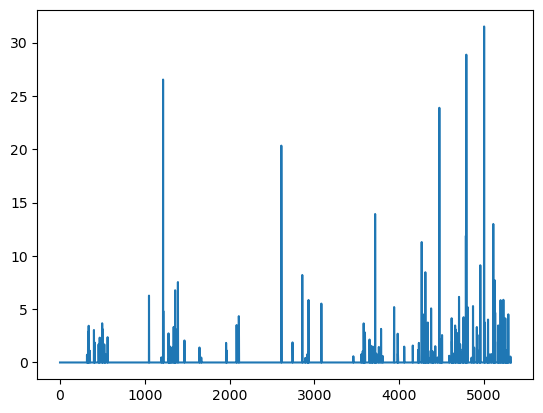

In [252]:
plt.plot(data['nearSurfRain'].to_numpy())

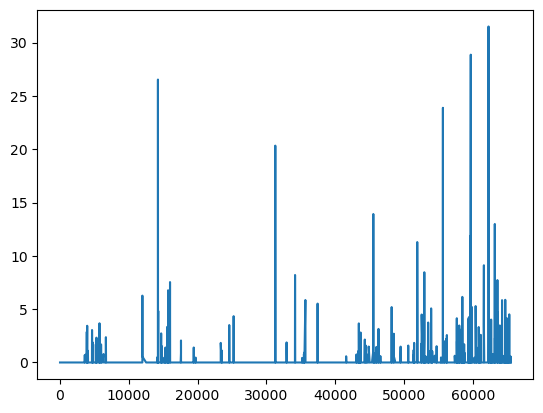

In [147]:
plt.plot(data['nearSurfRain'])

In [297]:
# Assuming you have loaded your data into a DataFrame called 'data'

# Define your threshold for rain (8mm/hr)
rain_threshold = 5

# Label data based on precipitation rate
data['label'] = np.where(data['nearSurfRain'] >= rain_threshold, 1, 0)

# Drop rows with missing values
#data.dropna(inplace=True)

# Define features and target variable
features = ['LATITUDE', 
            'LONGITUDE',
            # 'Neutral Wind Speed at 10m (TAO)',
            # 'cos(Wind Direction (TAO))',
            # 'sin(Wind Direction (TAO))',
            'Relative Humidity (TAO)',] 
            # 'Sea Surface Temperature (TAO)',
            # 'Air Temperature (TAO)',
            # # 'mean WSPD_10N 110min',
            # # 'mean cosWDIR 110min',
            # # 'mean sinWDIR 110min',
            # 'std. dev. WSPD_10N 110min',
            # 'std. dev. cosWDIR 110min',
            #'std. dev. sinWDIR 110min']
target = 'label'

# Split data into features and target
X = data[features]
y = data[target]

# Standardize features
scaler = StandardScaler()
#X_scaled = scaler.fit_transform(X)
mean = X.mean(axis=0)
std = X.std(axis=0)
X_scaled = (X - mean)/ std

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Build the model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    # Dense(8, activation='relu'),
    # Dropout(0.2),
    # Dense(8, activation='relu'),
    # Dropout(0.2),
    # Dense(8, activation='relu'),
    # Dropout(0.2),
    # Dense(8, activation='relu'),
    # Dropout(0.2),
    # Dense(8, activation='relu'),
    # Dropout(0.2),
    # Dense(8, activation='relu'),
    # Dropout(0.2),
    # Dense(7, activation='relu'),
    # Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# model = Sequential([
#     Dense(8, activation='exponential', input_shape=(X_train.shape[1],)),
#     Dropout(0.2),
#     # Dense(8, activation='exponential'),
#     # Dropout(0.2),
#     # Dense(8, activation='exponential'),
#     # Dropout(0.2),
#     # Dense(8, activation='exponential'),
#     # Dropout(0.2),
#     # Dense(8, activation='exponential'),
#     # Dropout(0.2),
#     # Dense(8, activation='exponential'),
#     # Dropout(0.2),
#     # Dense(8, activation='exponential'),
#     # Dropout(0.2),
#     # Dense(7, activation='relu'),
#     # Dropout(0.2),
#     Dense(1, activation='sigmoid')
# ])

# Compile the model
# model.compile(optimizer=Adam(learning_rate=0.001),
#               loss='binary_crossentropy',
#               metrics=['accuracy'])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=1000, validation_split=0.2)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

Epoch 1/50


/home/shikhar.rai/anaconda3/envs/tfXarr/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.3994 - loss: 0.7312 - val_accuracy: 0.6157 - val_loss: 0.6577
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6347 - loss: 0.6558 - val_accuracy: 0.8907 - val_loss: 0.5940
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8511 - loss: 0.5924 - val_accuracy: 0.9894 - val_loss: 0.5374
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9493 - loss: 0.5343 - val_accuracy: 0.9976 - val_loss: 0.4864
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9849 - loss: 0.4840 - val_accuracy: 0.9976 - val_loss: 0.4392
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9904 - loss: 0.4363 - val_accuracy: 0.9976 - val_loss: 0.3953
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9930 - loss: 0.3911 - val_accuracy: 0.9976 - val_loss: 0.3542
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9937 - loss: 0.3549 - val_accuracy: 0.9976 - val_loss: 0.3157
Epoch 9/50


In [298]:
# Make predictions
predictions = model.predict(X_test)


#plt.scatter(predicted_rain_l, y_train, s = 0.2)
# # Display predictions
# print(predictions)



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [299]:
y_test

count
2646     0
24700    0
45905    0
5072     0
46616    0
        ..
48267    0
5881     0
664      0
36762    0
54634    0
Name: label, Length: 1064, dtype: int64

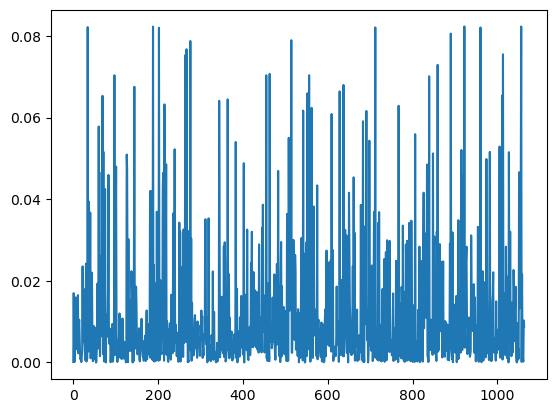

In [300]:
plt.plot(predictions)

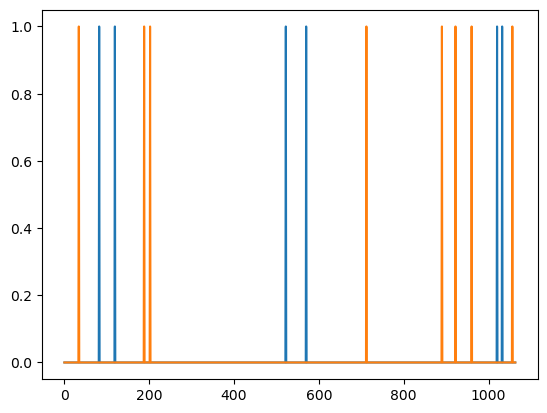

In [304]:
predicted_rain_labels = np.where(predictions >= 0.08, 1, 0)
#
plt.plot(y_test.to_numpy())
plt.plot(predicted_rain_labels)

In [57]:
model.save("Rain.h5")

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cdist, cosine
from scipy.ndimage import convolve1d
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS
from sklearn.cluster import SpectralClustering
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import tensorflow as tf
from joblib import Parallel, delayed

from matplotlib import cm
import matplotlib.cbook as cbook
import matplotlib.colors as colors

import pandas as pd
import xarray as xr
from netCDF4 import Dataset, num2date, date2num
from datetime import datetime, timedelta
import os

import seaborn as sns
import cmocean as cmocn

%matplotlib inline

In [59]:
ds = xr.open_dataset('../plotting2_xarray/rainFlagRemovedBuoyDataBadQualityRemovedMatchup.nc')
df = ds.to_dataframe()
df_orig = df.copy()

In [60]:
df['cos(Direction Difference (QuikSCAT - TAO))'] = np.cos(np.deg2rad(df['Direction Difference (QuikSCAT - TAO)']))
df['sin(Direction Difference (QuikSCAT - TAO))'] = np.sin(np.deg2rad(df['Direction Difference (QuikSCAT - TAO)']))


df['cos(Wind Direction (TAO))'] = np.cos(np.deg2rad(df['Wind Direction (TAO)']))
df['sin(Wind Direction (TAO))'] = np.sin(np.deg2rad(df['Wind Direction (TAO)']))

df['cos(Wind Direction (QuikSCAT))'] = np.cos(np.deg2rad(df['Wind Direction (QuikSCAT)']))
df['sin(Wind Direction (QuikSCAT))'] = np.sin(np.deg2rad(df['Wind Direction (QuikSCAT)']))


for timeWindow in range(10,730,10):
    if timeWindow == 10:
        df[f'cos (Direction) Difference {timeWindow}min (QuikSCAT - TAO)'] = df['cos(Wind Direction (QuikSCAT))'] - df['cos(Wind Direction (TAO))']
        df[f'sin (Direction) Difference {timeWindow}min (QuikSCAT - TAO)'] = df['sin(Wind Direction (QuikSCAT))'] - df['sin(Wind Direction (TAO))']

        df[f'speed Difference {timeWindow}min (QuikSCAT - TAO)'] = df['Wind Speed (QuikSCAT)'] - df['Neutral Wind Speed at 10m (TAO)']
    else:
        df[f'cos (Direction) Difference {timeWindow}min (QuikSCAT - TAO)'] = df['cos(Wind Direction (QuikSCAT))'] - df[f'mean cosWDIR {timeWindow}min']
        df[f'sin (Direction) Difference {timeWindow}min (QuikSCAT - TAO)'] = df['sin(Wind Direction (QuikSCAT))'] - df[f'mean sinWDIR {timeWindow}min']
        df[f'speed Difference {timeWindow}min (QuikSCAT - TAO)'] = df['Wind Speed (QuikSCAT)'] - df[f'mean WSPD_10N {timeWindow}min']
    

/tmp/ipykernel_1990649/3614314299.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'speed Difference {timeWindow}min (QuikSCAT - TAO)'] = df['Wind Speed (QuikSCAT)'] - df[f'mean WSPD_10N {timeWindow}min']
/tmp/ipykernel_1990649/3614314299.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'cos (Direction) Difference {timeWindow}min (QuikSCAT - TAO)'] = df['cos(Wind Direction (QuikSCAT))'] - df[f'mean cosWDIR {timeWindow}min']
/tmp/ipykernel_1990649/3614314299.py:20: PerformanceWarning: DataFrame is highly fragmente

In [61]:
df

,Wind Direction (TAO),WDIR_QC,WDIR_DM,Wind Speed (TAO),WSPD_QC,WSPD_DM,Zonal Wind Speed (TAO),Meridional Wind Speed (TAO),Sea Surface Temperature (TAO),SST_QC,...,speed Difference 690min (QuikSCAT - TAO),cos (Direction) Difference 700min (QuikSCAT - TAO),sin (Direction) Difference 700min (QuikSCAT - TAO),speed Difference 700min (QuikSCAT - TAO),cos (Direction) Difference 710min (QuikSCAT - TAO),sin (Direction) Difference 710min (QuikSCAT - TAO),speed Difference 710min (QuikSCAT - TAO),cos (Direction) Difference 720min (QuikSCAT - TAO),sin (Direction) Difference 720min (QuikSCAT - TAO),speed Difference 720min (QuikSCAT - TAO)
count,,,,,,,,,,,,,,,,,,,,,
0,123.600006,2.0,b'D',5.39,2.0,b'D',-2.98,4.49,23.745001,2.0,...,-0.234573,0.089942,0.080337,-0.234573,0.093605,0.083993,-0.234331,0.093605,0.083993,-0.234331
1,128.200012,2.0,b'D',5.30,2.0,b'D',-3.28,4.17,23.743000,2.0,...,-0.313397,0.073462,0.068829,-0.313397,0.077125,0.072485,-0.313155,0.077125,0.072485,-0.313155
2,128.700012,2.0,b'D',5.04,2.0,b'D',-3.15,3.93,23.938000,2.0,...,0.066849,0.082330,0.078573,0.066849,0.084389,0.080358,0.069859,0.084389,0.080358,0.069859
3,129.399994,2.0,b'D',5.46,2.0,b'D',-3.46,4.22,23.927999,2.0,...,0.093568,0.074663,0.072886,0.093568,0.076722,0.074672,0.096577,0.076722,0.074672,0.096577
4,132.200012,2.0,b'D',5.52,2.0,b'D',-3.70,4.09,23.716999,2.0,...,0.370070,0.028272,0.065863,0.357562,0.025757,0.063377,0.371263,0.027645,0.065058,0.365304
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244382,217.300003,2.0,b'D',6.46,2.0,b'D',-5.14,-3.91,26.746000,2.0,...,-0.149066,-0.075701,0.127019,-0.145982,-0.075701,0.127019,-0.145982,-0.075267,0.126758,-0.161620
244383,216.000000,2.0,b'D',5.79,2.0,b'D',-4.68,-3.40,26.754999,2.0,...,-0.720741,-0.079911,0.139517,-0.717656,-0.079911,0.139517,-0.717656,-0.080205,0.140956,-0.752889
244384,218.500000,2.0,b'D',9.70,2.0,b'D',-7.59,-6.04,26.757000,2.0,...,0.049676,-0.043482,0.062978,0.047467,-0.042740,0.061865,0.057463,-0.043632,0.063080,0.039835


In [62]:
df.keys()

Index(['Wind Direction (TAO)', 'WDIR_QC', 'WDIR_DM', 'Wind Speed (TAO)',
       'WSPD_QC', 'WSPD_DM', 'Zonal Wind Speed (TAO)',
       'Meridional Wind Speed (TAO)', 'Sea Surface Temperature (TAO)',
       'SST_QC',
       ...
       'speed Difference 690min (QuikSCAT - TAO)',
       'cos (Direction) Difference 700min (QuikSCAT - TAO)',
       'sin (Direction) Difference 700min (QuikSCAT - TAO)',
       'speed Difference 700min (QuikSCAT - TAO)',
       'cos (Direction) Difference 710min (QuikSCAT - TAO)',
       'sin (Direction) Difference 710min (QuikSCAT - TAO)',
       'speed Difference 710min (QuikSCAT - TAO)',
       'cos (Direction) Difference 720min (QuikSCAT - TAO)',
       'sin (Direction) Difference 720min (QuikSCAT - TAO)',
       'speed Difference 720min (QuikSCAT - TAO)'],
      dtype='object', length=1553)

In [98]:
features

['LATITUDE',
 'LONGITUDE',
 'Neutral Wind Speed at 10m (TAO)',
 'cos(Wind Direction (TAO))',
 'sin(Wind Direction (TAO))',
 'Relative Humidity (TAO)',
 'Sea Surface Temperature (TAO)',
 'Air Temperature (TAO)',
 'mean WSPD_10N 110min',
 'mean cosWDIR 110min',
 'mean sinWDIR 110min',
 'std. dev. WSPD_10N 110min',
 'std. dev. cosWDIR 110min',
 'std. dev. sinWDIR 110min']

In [117]:
# 'SST', 'U10N', 'U10_direction', 
#             'twoHrStdWspd', 'twoHrStdWdir', 
#             'AIRT', 'RH'

subDF = df[features]

In [118]:
subDF

,LATITUDE,LONGITUDE,Neutral Wind Speed at 10m (TAO),cos(Wind Direction (TAO)),sin(Wind Direction (TAO)),Relative Humidity (TAO),Sea Surface Temperature (TAO),Air Temperature (TAO),mean WSPD_10N 110min,mean cosWDIR 110min,mean sinWDIR 110min,std. dev. WSPD_10N 110min,std. dev. cosWDIR 110min,std. dev. sinWDIR 110min
count,,,,,,,,,,,,,,
0,-8.0,265.0,5.926161,-0.553392,0.832921,73.830002,23.745001,22.930000,6.058749,-0.605820,0.792423,0.224447,0.055737,0.044058
1,-8.0,265.0,5.836925,-0.618409,0.785857,73.300003,23.743000,22.840000,6.058749,-0.605820,0.792423,0.224447,0.055737,0.044058
2,-8.0,265.0,5.541527,-0.625243,0.780430,75.730003,23.938000,23.200001,5.988270,-0.644278,0.761760,0.487927,0.051294,0.044687
3,-8.0,265.0,5.992860,-0.634730,0.772734,75.599998,23.927999,23.190001,5.988270,-0.644278,0.761760,0.487927,0.051294,0.044687
4,-8.0,265.0,6.055364,-0.671721,0.740805,73.879997,23.716999,23.040001,5.765680,-0.650647,0.749736,0.432134,0.093075,0.076753
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244382,9.0,220.0,7.106239,-0.795474,-0.605988,95.000000,26.746000,25.129999,8.028184,-0.884789,-0.444030,1.254198,0.062369,0.126868
244383,9.0,220.0,6.371357,-0.809017,-0.587785,94.370003,26.754999,25.299999,8.028184,-0.884789,-0.444030,1.254198,0.062369,0.126868
244384,9.0,220.0,10.637788,-0.782608,-0.622514,88.559998,26.757000,26.260000,10.696507,-0.811389,-0.582261,0.514356,0.029860,0.041577


In [119]:
#X_new_scaled = scaler.transform(subDF)
X_new_scaled = scaler.fit_transform(subDF)
#X_new_scaled = (subDF - mean)/ std

In [120]:
predictions = model.predict(X_new_scaled)

4648/4648 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step


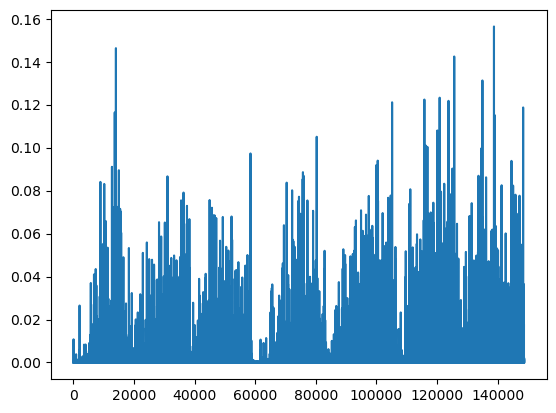

In [121]:
plt.plot(predictions)

In [132]:
predicted_rain_labels = np.where(predictions >= 0.01, 1, 0)

In [133]:
np.sum(predicted_rain_labels ==1)

3323

In [134]:
df['predicted_rain_labels'] = predicted_rain_labels

/tmp/ipykernel_1990649/2959594119.py:9: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  s = sns.histplot(subDF, x=xlabel, y = ylabel,#levels=10,
/tmp/ipykernel_1990649/2959594119.py:15: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  s = sns.histplot(subDF, x=xlabel, y = ylabel,#levels=10,


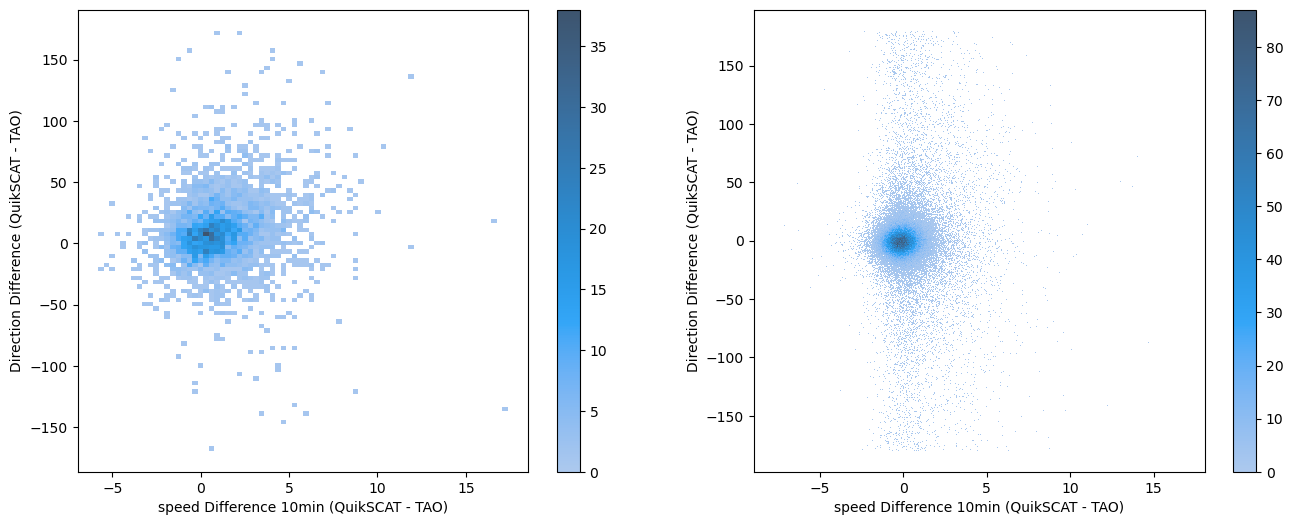

In [135]:
xlabel = 'speed Difference 10min (QuikSCAT - TAO)'
ylabel = 'Direction Difference (QuikSCAT - TAO)'

fig,  axes = plt.subplots(ncols = 2, figsize=(16,6))

ax = axes[0]

subDF = df.loc[df['predicted_rain_labels'] == 1]
s = sns.histplot(subDF, x=xlabel, y = ylabel,#levels=10, 
                common_norm=True, cbar = True,#hue='label', 
                palette = sns.color_palette("bright"), ax = ax)

ax = axes[1]
subDF = df.loc[df['predicted_rain_labels'] == 0]
s = sns.histplot(subDF, x=xlabel, y = ylabel,#levels=10, 
                 common_norm=True, cbar = True,#hue='label',
                palette = sns.color_palette("bright"), ax = ax)

/tmp/ipykernel_1990649/873671812.py:9: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  s = sns.histplot(df, x=xlabel, y = ylabel,#levels=10,
/tmp/ipykernel_1990649/873671812.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  s = sns.countplot(df, x='predicted_rain_labels',palette = sns.color_palette("bright"), ax = ax)
/tmp/ipykernel_1990649/873671812.py:22: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  s = sns.countplot(df, x='predicted_rain_labels',palette = sns.color_palette("bright"), ax = ax)


Text(0.1, 0.95, 'B')

/home/shikhar.rai/anaconda3/envs/tfXarr/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


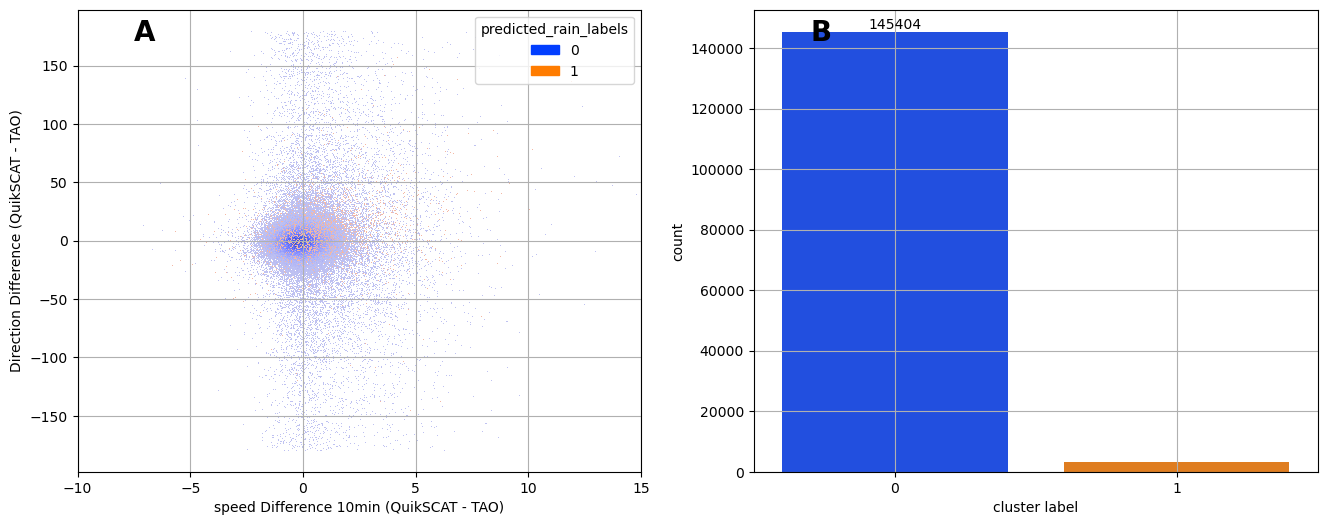

In [136]:
fig,  axes = plt.subplots(ncols = 2, figsize=(16,6))

ax = axes[0]
# ax.remove()  # Remove the existing second subplot
# ax = fig.add_subplot(121, projection='polar')
xlabel = 'speed Difference 10min (QuikSCAT - TAO)'
ylabel = 'Direction Difference (QuikSCAT - TAO)'

s = sns.histplot(df, x=xlabel, y = ylabel,#levels=10, 
                hue='predicted_rain_labels', common_norm=True, #cbar = True,
                palette = sns.color_palette("bright"), ax = ax)

ax.grid(visible=True, which='both', axis='both')

ax.text(0.1, 0.95, 'A', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 20)

ax.set_xlim(-10,15)

ax = axes[1]
s = sns.countplot(df, x='predicted_rain_labels',palette = sns.color_palette("bright"), ax = ax)
s.bar_label(s.containers[0])

ax.grid(visible=True, which='both', axis='both')
ax.set_xlabel('cluster label')
#ax.set_ylabel('cluster label')

ax.text(0.1, 0.95, 'B', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 20)


#plt.savefig('PDF_byCluster_10min.png', dpi=100)

/tmp/ipykernel_1990649/3282684746.py:28: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  s = sns.histplot(df, x=xlabel, y = ylabel,#levels=10,
/tmp/ipykernel_1990649/3282684746.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  s = sns.countplot(df, x='label',palette = sns.color_palette("bright"), ax = ax)
/tmp/ipykernel_1990649/3282684746.py:41: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  s = sns.countplot(df, x='label',palette = sns.color_palette("bright"), ax = ax)


Text(0.1, 0.95, 'B')

/home/shikhar.rai/anaconda3/envs/tfXarr/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


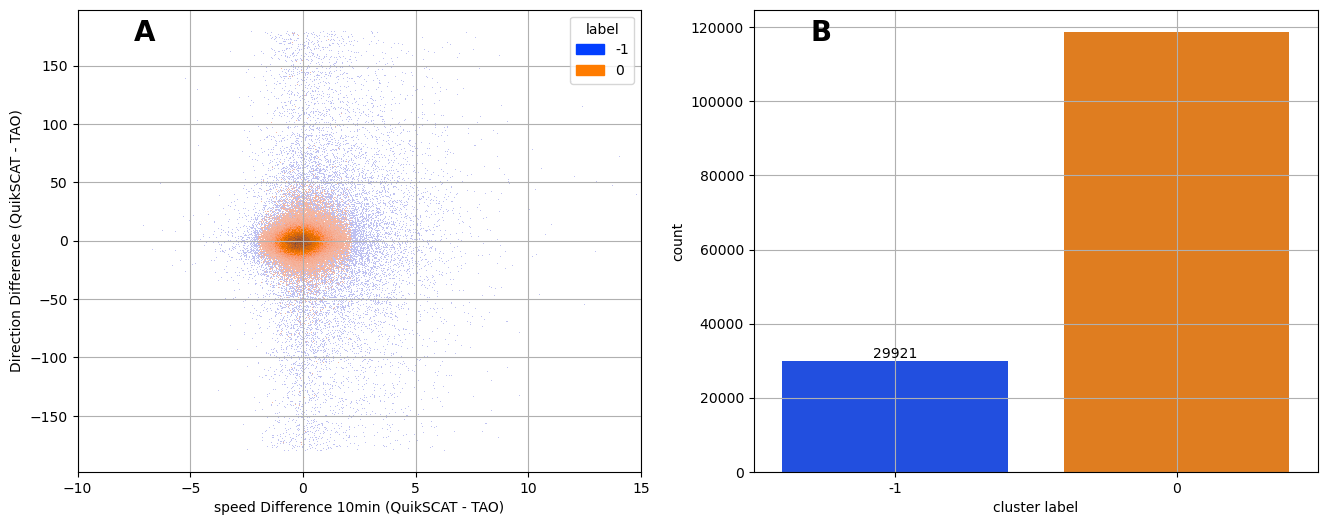

In [137]:
selectX = ['speed Difference 10min (QuikSCAT - TAO)',
           'cos (Direction) Difference 10min (QuikSCAT - TAO)',
           'cos (Direction) Difference 10min (QuikSCAT - TAO)']



X = df[selectX]

normX = (X - X.mean(axis=0))/ X.std(axis=0)

# kmeans = KMeans(n_clusters=17, random_state=0, n_init="auto", max_iter = 10000).fit(normX)
# df['label'] = kmeans.labels_

dbscan = DBSCAN(eps=0.15, min_samples= 500)
df['label'] = dbscan.fit_predict(normX)

# optics = OPTICS(min_samples=50 ) #cluster_method='dbscan', eps=0.25)
# df['label'] = optics.fit_predict(normX)

fig,  axes = plt.subplots(ncols = 2, figsize=(16,6))

ax = axes[0]
# ax.remove()  # Remove the existing second subplot
# ax = fig.add_subplot(121, projection='polar')
xlabel = 'speed Difference 10min (QuikSCAT - TAO)'
ylabel = 'Direction Difference (QuikSCAT - TAO)'

s = sns.histplot(df, x=xlabel, y = ylabel,#levels=10, 
                hue='label', common_norm=True, #cbar = True,
                palette = sns.color_palette("bright"), ax = ax)

ax.grid(visible=True, which='both', axis='both')

ax.text(0.1, 0.95, 'A', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 20)

ax.set_xlim(-10,15)

ax = axes[1]
s = sns.countplot(df, x='label',palette = sns.color_palette("bright"), ax = ax)
s.bar_label(s.containers[0])

ax.grid(visible=True, which='both', axis='both')
ax.set_xlabel('cluster label')
#ax.set_ylabel('cluster label')

ax.text(0.1, 0.95, 'B', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 20)


#plt.savefig('PDF_byCluster_10min.png', dpi=100)

In [138]:
goodBad = np.array(['good' for i in range(len(df))])
print(len(goodBad))
mask = df['label'].isin([-1])
goodBad[mask] = 'bad'
df['GoodBad'] = goodBad

148727


In [139]:
def getGoodBad(lat, lon, df):
    isPresent = False
    lon = (lon + 360)%360
    subDF = df.loc[df['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == lon]
    if len(subDF) > 0:
        isPresent = True
    if isPresent:    
        goodCount = len(subDF.loc[subDF['GoodBad'] == 'good'])/len(subDF)*100
        badCount = len(subDF.loc[subDF['GoodBad'] == 'bad'])/len(subDF)*100
        return f' {goodCount:3.0f},{badCount:3.0f}'
    else:
        return ''

def getBadPercent(lat, lon, df):
    isPresent = False
    lon = (lon + 360)%360
    subDF = df.loc[df['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == lon]
    if len(subDF) > 0:
        isPresent = True
    
    if isPresent:
        goodCount = len(subDF.loc[subDF['GoodBad'] == 'good'])/len(subDF)*100
        badCount = len(subDF.loc[subDF['GoodBad'] == 'bad'])/len(subDF)*100
        
        return badCount
    else:
        return -999

def getCount(lat, lon, df):
    isPresent = False
    lon = (lon + 360)%360
    subDF = df.loc[df['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == lon]
    if len(subDF) > 0:
        isPresent = True
    if isPresent:
        count = len(subDF) #.loc[subDF['GoodBad'] == 'good'])/len(subDF)*100
        return count
    else:
        return -999


def getSpeedCorrelation(lat, lon, df, timeWindow=10):
    isPresent = False
    lon = (lon + 360)%360
    subDF = df.loc[df['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == lon]
    if len(subDF) > 0:
        isPresent = True
    if isPresent:
        if timeWindow == 10:
            TAOlabel = 'Neutral Wind Speed at 10m (TAO)'
        else:
            TAOlabel = f'mean WSPD_10N {timeWindow}min'
        QSspeed = subDF['Wind Speed (QuikSCAT)'].to_numpy()
        TAOspeed = subDF[TAOlabel].to_numpy()
        corr = np.corrcoef(QSspeed, TAOspeed)[0,1]
        return corr
    else:
        return -999

def getDirCorrelation(lat, lon, df, timeWindow=10):
    isPresent = False
    lon = (lon + 360)%360
    subDF = df.loc[df['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == lon]
    if len(subDF) > 0:
        isPresent = True
    if isPresent:
        if timeWindow == 10:
            TAOlabel = 'Wind Direction (TAO)'
            TAOdir = subDF[TAOlabel].to_numpy()
        else:
            TAOlabel = f'mean cosWDIR {timeWindow}min'
            cos = subDF[TAOlabel].to_numpy()

            TAOlabel = f'mean sinWDIR {timeWindow}min'
            sin = subDF[TAOlabel].to_numpy()

            TAOdir = (np.rad2deg(np.arctan2(sin, cos))+360)%360
            # TAOlabel = f'mean WDIR {timeWindow}min'
        #print(TAOdir)
        QSdir = subDF['Wind Direction (QuikSCAT)'].to_numpy()        
        corr = np.corrcoef(QSdir, TAOdir)[0,1]
        return corr
    else:
        return -999

def getCosDirCorrelation(lat, lon, df, timeWindow=10):
    isPresent = False
    lon = (lon + 360)%360
    subDF = df.loc[df['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == lon]
    if len(subDF) > 0:
        isPresent = True
    if isPresent:
        if timeWindow == 10:
            TAOlabel = 'cos(Wind Direction (TAO))'
        else:
            TAOlabel = f'mean cosWDIR {timeWindow}min'
        QSdir = subDF['cos(Wind Direction (QuikSCAT))'].to_numpy()
        TAOdir = subDF[TAOlabel].to_numpy()
        corr = np.corrcoef(QSdir, TAOdir)[0,1]
        return corr
    else:
        return -999

def getSinDirCorrelation(lat, lon, df, timeWindow=10):
    isPresent = False
    lon = (lon + 360)%360
    subDF = df.loc[df['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == lon]
    if len(subDF) > 0:
        isPresent = True
    if isPresent:
        if timeWindow == 10:
            TAOlabel = 'sin(Wind Direction (TAO))'
        else:
            TAOlabel = f'mean sinWDIR {timeWindow}min'
        QSdir = subDF['sin(Wind Direction (QuikSCAT))'].to_numpy()
        TAOdir = subDF[TAOlabel].to_numpy()
        corr = np.corrcoef(QSdir, TAOdir)[0,1]
        return corr
    else:
        return -999

def getXSpeedCorrelation(lat, lon, df, timeWindow=10):
    isPresent = False
    lon = (lon + 360)%360
    subDF = df.loc[df['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == lon]
    if len(subDF) > 0:
        isPresent = True
    if isPresent:
        if timeWindow == 10:
            TAOlabel = 'Zonal Wind Speed (TAO)'
        else:
            TAOlabel = f'mean Ux_10N {timeWindow}min'
        QSspeed_x = subDF['Zonal Wind Speed (QuikSCAT)']
        TAOspeed_x = subDF[TAOlabel]
        corr = np.corrcoef(QSspeed_x, TAOspeed_x)[0,1]
        return corr
    else:
        return -999

def getYSpeedCorrelation(lat, lon, df, timeWindow=10):
    isPresent = False
    lon = (lon + 360)%360
    subDF = df.loc[df['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == lon]
    if len(subDF) > 0:
        isPresent = True
        if timeWindow == 10:
            TAOlabel = 'Meridional Wind Speed (TAO)'
        else:
            TAOlabel = f'mean Vy_10N {timeWindow}min'
    if isPresent:
        QSspeed_y = subDF['Meridional Wind Speed (QuikSCAT)']
        TAOspeed_y = subDF[TAOlabel]
        corr = np.corrcoef(QSspeed_y, TAOspeed_y)[0,1]
        return corr
    else:
        return -999


def getSpeedStd(lat, lon, df, timeWindow=10):
    isPresent = False
    lon = (lon + 360)%360
    subDF = df.loc[df['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == lon]
    if len(subDF) > 0:
        isPresent = True
    if isPresent:
        TAOlabel = f'std. dev. WSPD_10N {timeWindow}min'
        TAOspeedStd = np.nanmean(subDF[TAOlabel].to_numpy())
        return TAOspeedStd
    else:
        return -999

def getcosDirStd(lat, lon, df, timeWindow=10):
    isPresent = False
    lon = (lon + 360)%360
    subDF = df.loc[df['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == lon]
    if len(subDF) > 0:
        isPresent = True
    if isPresent:
        TAOlabel = f'std. dev. cosWDIR {timeWindow}min'
        TAO_Std = np.nanmean(subDF[TAOlabel].to_numpy())
        return TAO_Std
    else:
        return -999

def getsinDirStd(lat, lon, df, timeWindow=10):
    isPresent = False
    lon = (lon + 360)%360
    subDF = df.loc[df['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == lon]
    if len(subDF) > 0:
        isPresent = True
    if isPresent:
        TAOlabel = f'std. dev. sinWDIR {timeWindow}min'
        TAO_Std = np.nanmean(subDF[TAOlabel].to_numpy())
        return TAO_Std
    else:
        return -999
    

In [140]:
df.head()

,Wind Direction (TAO),WDIR_QC,WDIR_DM,Wind Speed (TAO),WSPD_QC,WSPD_DM,Zonal Wind Speed (TAO),Meridional Wind Speed (TAO),Sea Surface Temperature (TAO),SST_QC,...,speed Difference 700min (QuikSCAT - TAO),cos (Direction) Difference 710min (QuikSCAT - TAO),sin (Direction) Difference 710min (QuikSCAT - TAO),speed Difference 710min (QuikSCAT - TAO),cos (Direction) Difference 720min (QuikSCAT - TAO),sin (Direction) Difference 720min (QuikSCAT - TAO),speed Difference 720min (QuikSCAT - TAO),predicted_rain_labels,label,GoodBad
count,,,,,,,,,,,,,,,,,,,,,
0,123.600006,2.0,b'D',5.39,2.0,b'D',-2.98,4.49,23.745001,2.0,...,-0.234573,0.093605,0.083993,-0.234331,0.093605,0.083993,-0.234331,0,0,good
1,128.200012,2.0,b'D',5.30,2.0,b'D',-3.28,4.17,23.743000,2.0,...,-0.313397,0.077125,0.072485,-0.313155,0.077125,0.072485,-0.313155,0,0,good
2,128.700012,2.0,b'D',5.04,2.0,b'D',-3.15,3.93,23.938000,2.0,...,0.066849,0.084389,0.080358,0.069859,0.084389,0.080358,0.069859,0,0,good
3,129.399994,2.0,b'D',5.46,2.0,b'D',-3.46,4.22,23.927999,2.0,...,0.093568,0.076722,0.074672,0.096577,0.076722,0.074672,0.096577,0,0,good
4,132.200012,2.0,b'D',5.52,2.0,b'D',-3.70,4.09,23.716999,2.0,...,0.357562,0.025757,0.063377,0.371263,0.027645,0.065058,0.365304,0,0,good


/home/shikhar.rai/anaconda3/envs/tfXarr/lib/python3.12/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/home/shikhar.rai/anaconda3/envs/tfXarr/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/shikhar.rai/anaconda3/envs/tfXarr/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/shikhar.rai/anaconda3/envs/tfXarr/lib/python3.12/site-packages/pyproj/transformer.py:820: UserWarning: Warning: converting a masked element to nan.
  return self._transformer._transform_point(
/home/shikhar.rai/anaconda3/envs/tfXarr/lib/python3.12/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/home/shikhar.rai/anaconda3/envs/tfXarr/lib/python

Text(0.1, 0.95, 'D.  Wind Direction Correlation for Matchups without Rain')

/home/shikhar.rai/anaconda3/envs/tfXarr/lib/python3.12/site-packages/pyproj/transformer.py:820: UserWarning: Warning: converting a masked element to nan.
  return self._transformer._transform_point(
/home/shikhar.rai/anaconda3/envs/tfXarr/lib/python3.12/site-packages/pyproj/transformer.py:820: UserWarning: Warning: converting a masked element to nan.
  return self._transformer._transform_point(
/home/shikhar.rai/anaconda3/envs/tfXarr/lib/python3.12/site-packages/pyproj/transformer.py:820: UserWarning: Warning: converting a masked element to nan.
  return self._transformer._transform_point(
/home/shikhar.rai/anaconda3/envs/tfXarr/lib/python3.12/site-packages/pyproj/transformer.py:820: UserWarning: Warning: converting a masked element to nan.
  return self._transformer._transform_point(
/home/shikhar.rai/anaconda3/envs/tfXarr/lib/python3.12/site-packages/pyproj/transformer.py:820: UserWarning: Warning: converting a masked element to nan.
  return self._transformer._transform_point(
/home

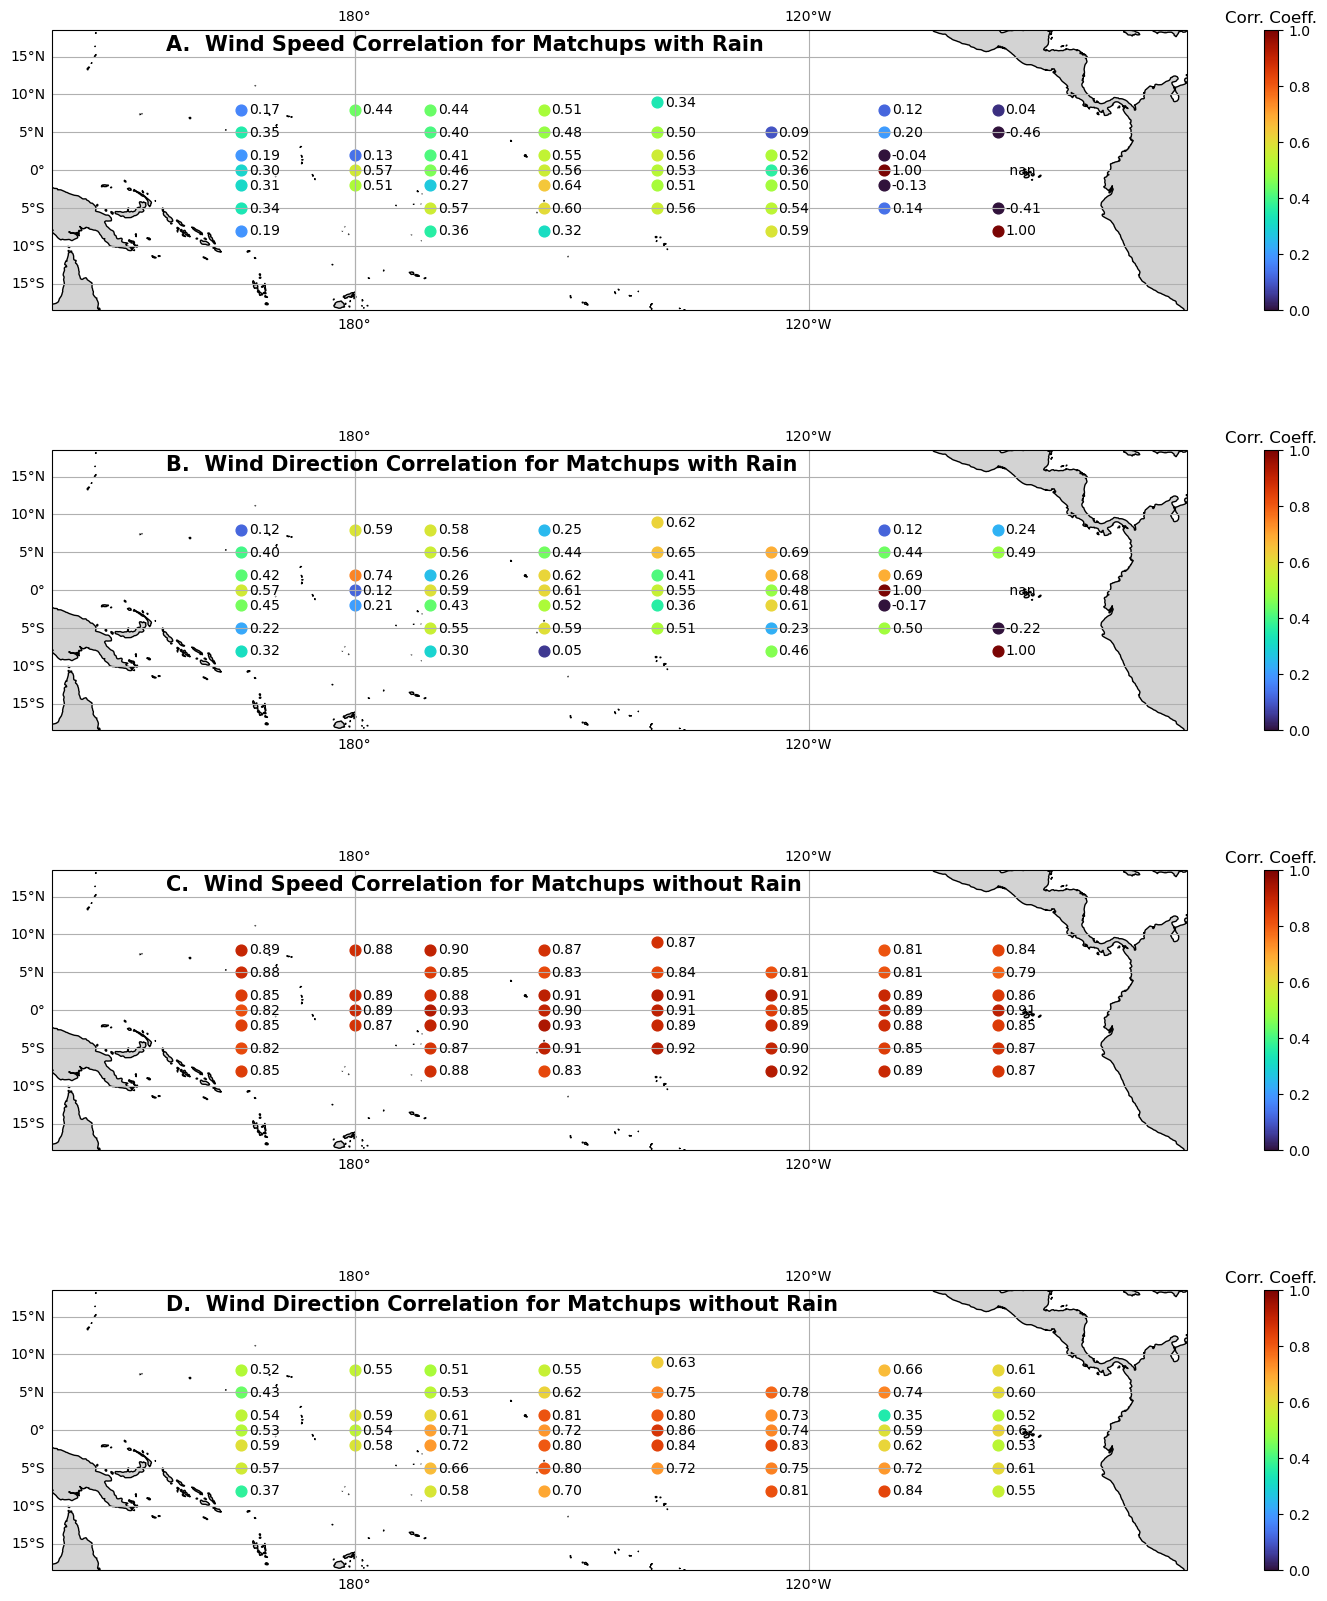

In [141]:
latList = [-9, -8, -5, -2, 0, 2, 5, 8, 9]
lonList = [-95, -110, -125, -140, -155, -170, -180, 165]

ylen = len(latList)
xlen = len(lonList)

taskList = []

for latId  in range(ylen):
    for lonId in range(xlen):
        taskList.append([latList[latId], lonList[lonId]])

ntasks = len(taskList)

import cartopy.crs as ccrs
import cartopy.feature as cfeature 

fig, axes = plt.subplots(nrows = 4, 
                       ncols = 1, 
                        figsize = (20,20),
                       subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)}, # "aspect": 1.2}, #1.2},
                       gridspec_kw = {'wspace':0.2, 'hspace':0.5}) 

land = cfeature.NaturalEarthFeature(
    category='physical',
    name='land',
    scale='50m',
    facecolor='lightgrey'  # Set the color to grey
)


subDF = df.loc[df['predicted_rain_labels'] == 1]
ax = axes[0] 
ax.add_feature(land)

ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True)
ax.coastlines()
for task in taskList:
    lat = task[0]
    lon = task[1]
    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    corr = getSpeedCorrelation(lat, lon, subDF)
    if corr != -999: 
        ax.text(xpos+1, lat-0.5, f'{corr:4.2f}')
        x = ax.scatter(xpos, lat, c=corr, vmin=0, vmax=1, s=60, cmap=cm.turbo)
    
cb = plt.colorbar(x, ax = ax)
cb.ax.set_title('Corr. Coeff.')

ax.text(0.1, 0.95, 'A.  Wind Speed Correlation for Matchups with Rain', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)



###################################################################################################################

ax = axes[1]
ax.add_feature(land)

ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True)
ax.coastlines()
for task in taskList:
    lat = task[0]
    lon = task[1]
    txt = getGoodBad(lat, lon, df)
    

    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    corr = getDirCorrelation(lat, lon, subDF)
    #print(corr)
    if corr != -999: 
        ax.text(xpos+1, lat-0.5, f'{corr:4.2f}')
        x = ax.scatter(xpos, lat, c=corr, vmin=0, vmax=1, s=60, cmap=cm.turbo)
    
cb = plt.colorbar(x, ax = ax)
cb.ax.set_title('Corr. Coeff.')

ax.text(0.1, 0.95, 'B.  Wind Direction Correlation for Matchups with Rain', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)

###################################################################################################################
subDF = df.loc[df['predicted_rain_labels'] == 0]
ax = axes[2] 
ax.add_feature(land)

ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True)
ax.coastlines()
for task in taskList:
    lat = task[0]
    lon = task[1]
    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    corr = getSpeedCorrelation(lat, lon, subDF)
    if corr != -999: 
        ax.text(xpos+1, lat-0.5, f'{corr:4.2f}')
        x = ax.scatter(xpos, lat, c=corr, vmin=0, vmax=1, s=60, cmap=cm.turbo)
    
cb = plt.colorbar(x, ax = ax)
cb.ax.set_title('Corr. Coeff.')

ax.text(0.1, 0.95, 'C.  Wind Speed Correlation for Matchups without Rain', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)



###################################################################################################################
ax = axes[3]
ax.add_feature(land)

ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True)
ax.coastlines()
for task in taskList:
    lat = task[0]
    lon = task[1]
    txt = getGoodBad(lat, lon, df)
    

    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    corr = getDirCorrelation(lat, lon, subDF)
    #print(corr)
    if corr != -999: 
        ax.text(xpos+1, lat-0.5, f'{corr:4.2f}')
        x = ax.scatter(xpos, lat, c=corr, vmin=0, vmax=1, s=60, cmap=cm.turbo)
    
cb = plt.colorbar(x, ax = ax)
cb.ax.set_title('Corr. Coeff.')

ax.text(0.1, 0.95, 'D.  Wind Direction Correlation for Matchups without Rain', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)

###################################################################################################################

/home/shikhar.rai/anaconda3/envs/tfXarr/lib/python3.12/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/home/shikhar.rai/anaconda3/envs/tfXarr/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/shikhar.rai/anaconda3/envs/tfXarr/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/shikhar.rai/anaconda3/envs/tfXarr/lib/python3.12/site-packages/pyproj/transformer.py:820: UserWarning: Warning: converting a masked element to nan.
  return self._transformer._transform_point(
/home/shikhar.rai/anaconda3/envs/tfXarr/lib/python3.12/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/home/shikhar.rai/anaconda3/envs/tfXarr/lib/python

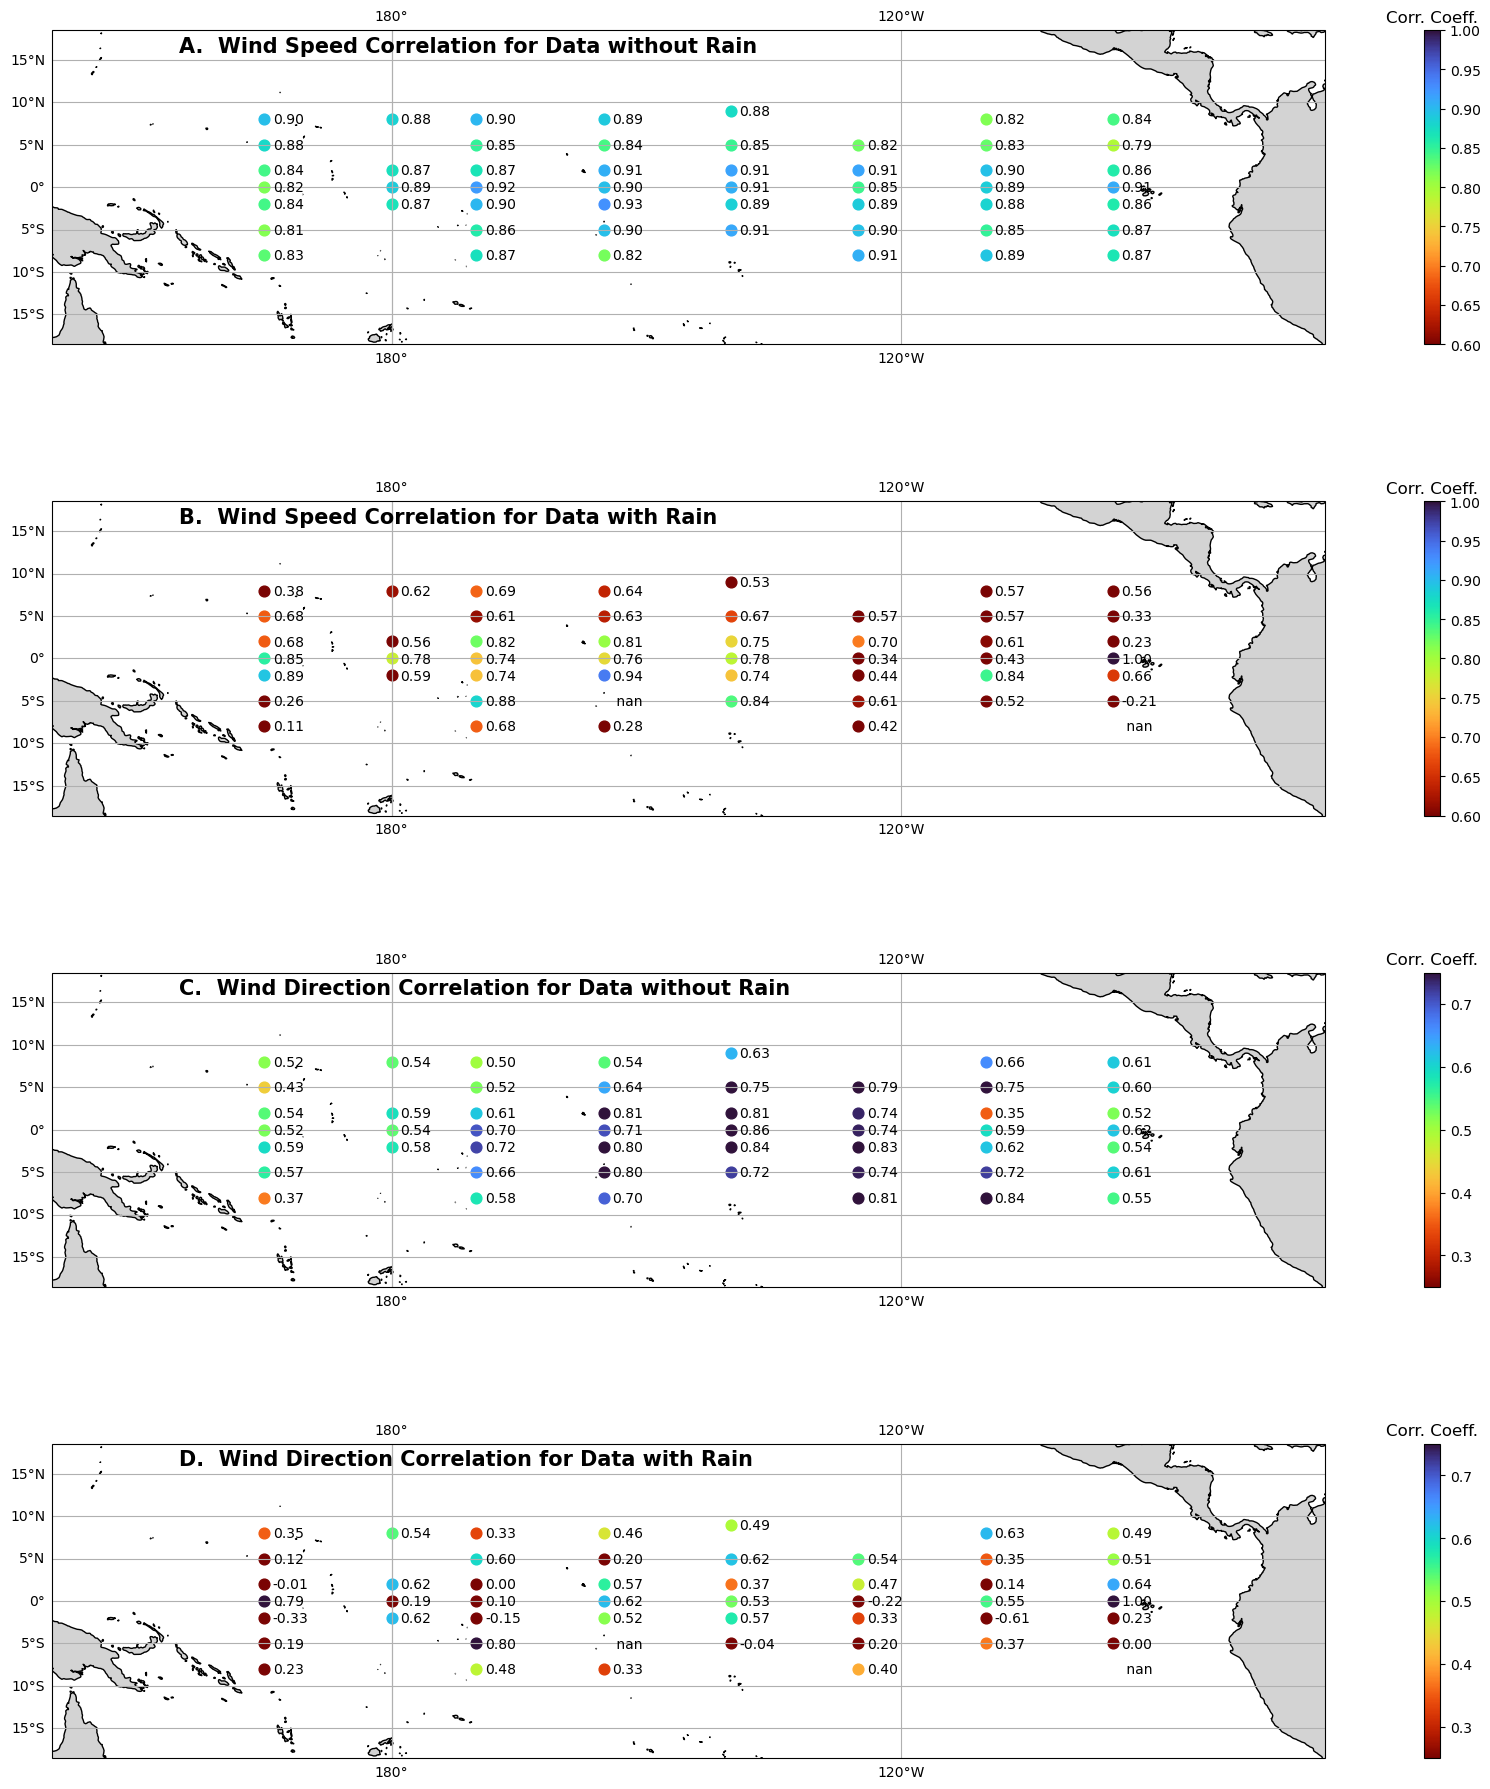

In [93]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature 
fig, axes = plt.subplots(nrows = 4, 
                       ncols = 1, 
                        figsize = (20,18),
                       subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)}, # "aspect": 1.2}, #1.2},
                       gridspec_kw = {'wspace':0.2, 'hspace':0.5}) 

land = cfeature.NaturalEarthFeature(
    category='physical',
    name='land',
    scale='50m',
    facecolor='lightgrey'  # Set the color to grey
)

subDF = df.loc[df['predicted_rain_labels'] == 0]
ax = axes[0]

ax.add_feature(land)

ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True)
ax.coastlines()
for task in taskList:
    lat = task[0]
    lon = task[1]
    #txt = getGoodBad(lat, lon, df)
    

    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    corr = getSpeedCorrelation(lat, lon, subDF)
    if corr != -999: 
        ax.text(xpos+1, lat-0.5, f'{corr:4.2f}')
        x = ax.scatter(xpos, lat, c=corr, vmin=0.6, vmax=1, s=60, cmap='turbo_r')
    
cb = plt.colorbar(x, ax = ax)
cb.ax.set_title('Corr. Coeff.')

ax.text(0.1, 0.95, 'A.  Wind Speed Correlation for Data without Rain', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)


ax = axes[2]

ax.add_feature(land)

ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True)
ax.coastlines()
for task in taskList:
    lat = task[0]
    lon = task[1]
    #txt = getGoodBad(lat, lon, df)
    

    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    corr = getDirCorrelation(lat, lon, subDF)
    if corr != -999: 
        ax.text(xpos+1, lat-0.5, f'{corr:4.2f}')
        x = ax.scatter(xpos, lat, c=corr, vmin=0.25, vmax=0.75, s=60, cmap='turbo_r')
    
cb = plt.colorbar(x, ax = ax)
cb.ax.set_title('Corr. Coeff.')
#ax.scatter(df['lon'], df['lat'], transform=ccrs.PlateCarree())

ax.text(0.1, 0.95, 'C.  Wind Direction Correlation for Data without Rain', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)


subDF = df.loc[df['predicted_rain_labels'] == 1]
ax = axes[1]

ax.add_feature(land)

ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True)
ax.coastlines()
for task in taskList:
    lat = task[0]
    lon = task[1]
    #txt = getGoodBad(lat, lon, df)
    

    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    corr = getSpeedCorrelation(lat, lon, subDF)
    if corr != -999: 
        ax.text(xpos+1, lat-0.5, f'{corr:4.2f}')
        x = ax.scatter(xpos, lat, c=corr, vmin=0.6, vmax=1, s=60, cmap='turbo_r')
    
cb = plt.colorbar(x, ax = ax)
cb.ax.set_title('Corr. Coeff.')

ax.text(0.1, 0.95, 'B.  Wind Speed Correlation for Data with Rain', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)


ax = axes[3]

ax.add_feature(land)

ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True)
ax.coastlines()
for task in taskList:
    lat = task[0]
    lon = task[1]
    #txt = getGoodBad(lat, lon, df)
    

    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    corr = getDirCorrelation(lat, lon, subDF)
    if corr != -999: 
        ax.text(xpos+1, lat-0.5, f'{corr:4.2f}')
        x = ax.scatter(xpos, lat, c=corr, vmin=0.25, vmax=0.75, s=60, cmap='turbo_r')
    
cb = plt.colorbar(x, ax = ax)
cb.ax.set_title('Corr. Coeff.')
#ax.scatter(df['lon'], df['lat'], transform=ccrs.PlateCarree())

ax.text(0.1, 0.95, 'D.  Wind Direction Correlation for Data with Rain', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)

plt.subplots_adjust(left = 0.01, right = 1, top =0.98 , bottom = 0.02, wspace=0 , hspace=0)
#plt.tight_layout()

plt.savefig('CorrWithAndWithoutRain.png', dpi=100)


In [ ]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature 
fig, axes = plt.subplots(nrows = 3, 
                       ncols = 1, 
                        figsize = (20,12),
                       subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)}, # "aspect": 1.2}, #1.2},
                       gridspec_kw = {'wspace':0.2, 'hspace':0.5}) 

land = cfeature.NaturalEarthFeature(
    category='physical',
    name='land',
    scale='50m',
    facecolor='lightgrey'  # Set the color to grey
)

ax = axes[0] 

ax.add_feature(land)


# ax.set_extent([140, -70, -5, 5]) 
# gridlines = ax.gridlines(draw_labels=True)
# ax.coastlines()
# for task in taskList:
#     lat = task[0]
#     lon = task[1]
#     txt = getGoodBad(lat, lon, df)
    

#     xpos = lon + 180
    
#     if xpos > 180:
#        xpos -= 360
#     if txt != '': 
#         badPercent = getBadPercent(lat, lon, df)
#         #print(badPercent)
#         ax.text(xpos, lat-0.5, txt)
#         x = ax.scatter(xpos, lat, c=badPercent, vmin=0, vmax=45, s=60, cmap='turbo')
    
# cb = plt.colorbar(x, ax = ax)
# cb.ax.set_title('% of Bad Matchups')
# #ax.scatter(df['lon'], df['lat'], transform=ccrs.PlateCarree())

# ax.text(0.1, 0.95, 'A.  Percentage of Bad Matchups', horizontalalignment='left',
#         verticalalignment='center', transform=ax.transAxes,
#         weight = 'heavy', fontsize = 15)


subDF = df.loc[df['predicted_rain_labels'] == 1]
ax = axes[1]

ax.add_feature(land)

ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True)
ax.coastlines()
for task in taskList:
    lat = task[0]
    lon = task[1]
    #txt = getGoodBad(lat, lon, df)
    

    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    corr = getSpeedCorrelation(lat, lon, subDF)
    if corr != -999: 
        ax.text(xpos+1, lat-0.5, f'{corr:4.2f}')
        x = ax.scatter(xpos, lat, c=corr, vmin=0.6, vmax=1, s=60, cmap='turbo_r')
    
cb = plt.colorbar(x, ax = ax)
cb.ax.set_title('Corr. Coeff.')

ax.text(0.1, 0.95, 'B.  Wind Speed Correlation', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)


ax = axes[2]

ax.add_feature(land)

ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True)
ax.coastlines()
for task in taskList:
    lat = task[0]
    lon = task[1]
    #txt = getGoodBad(lat, lon, df)
    

    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    corr = getDirCorrelation(lat, lon, subDF)
    if corr != -999: 
        ax.text(xpos+1, lat-0.5, f'{corr:4.2f}')
        x = ax.scatter(xpos, lat, c=corr, vmin=0.25, vmax=0.75, s=60, cmap='turbo_r')
    
cb = plt.colorbar(x, ax = ax)
cb.ax.set_title('Corr. Coeff.')
#ax.scatter(df['lon'], df['lat'], transform=ccrs.PlateCarree())

ax.text(0.1, 0.95, 'C.  Wind Direction Correlation', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)

plt.subplots_adjust(left = 0.01, right = 1, top =0.98 , bottom = 0.02, wspace=0 , hspace=0)
#plt.tight_layout()

#plt.savefig('goodVsBad.png', dpi=100)


In [ ]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature 
fig, axes = plt.subplots(nrows = 3, 
                       ncols = 1, 
                        figsize = (20,12),
                       subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)}, # "aspect": 1.2}, #1.2},
                       gridspec_kw = {'wspace':0.2, 'hspace':0.5}) 

land = cfeature.NaturalEarthFeature(
    category='physical',
    name='land',
    scale='50m',
    facecolor='lightgrey'  # Set the color to grey
)

ax = axes[0] 

ax.add_feature(land)


# ax.set_extent([140, -70, -5, 5]) 
# gridlines = ax.gridlines(draw_labels=True)
# ax.coastlines()
# for task in taskList:
#     lat = task[0]
#     lon = task[1]
#     txt = getGoodBad(lat, lon, df)
    

#     xpos = lon + 180
    
#     if xpos > 180:
#        xpos -= 360
#     if txt != '': 
#         badPercent = getBadPercent(lat, lon, df)
#         #print(badPercent)
#         ax.text(xpos, lat-0.5, txt)
#         x = ax.scatter(xpos, lat, c=badPercent, vmin=0, vmax=45, s=60, cmap='turbo')
    
# cb = plt.colorbar(x, ax = ax)
# cb.ax.set_title('% of Bad Matchups')
# #ax.scatter(df['lon'], df['lat'], transform=ccrs.PlateCarree())

# ax.text(0.1, 0.95, 'A.  Percentage of Bad Matchups', horizontalalignment='left',
#         verticalalignment='center', transform=ax.transAxes,
#         weight = 'heavy', fontsize = 15)


subDF = df #.loc[df['predicted_rain_labels'] == 1]
ax = axes[1]

ax.add_feature(land)

ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True)
ax.coastlines()
for task in taskList:
    lat = task[0]
    lon = task[1]
    #txt = getGoodBad(lat, lon, df)
    

    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    corr = getSpeedCorrelation(lat, lon, subDF)
    if corr != -999: 
        ax.text(xpos+1, lat-0.5, f'{corr:4.2f}')
        x = ax.scatter(xpos, lat, c=corr, vmin=0.6, vmax=1, s=60, cmap='turbo_r')
    
cb = plt.colorbar(x, ax = ax)
cb.ax.set_title('Corr. Coeff.')

ax.text(0.1, 0.95, 'B.  Wind Speed Correlation', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)


ax = axes[2]

ax.add_feature(land)

ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True)
ax.coastlines()
for task in taskList:
    lat = task[0]
    lon = task[1]
    #txt = getGoodBad(lat, lon, df)
    

    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    corr = getDirCorrelation(lat, lon, subDF)
    if corr != -999: 
        ax.text(xpos+1, lat-0.5, f'{corr:4.2f}')
        x = ax.scatter(xpos, lat, c=corr, vmin=0.25, vmax=0.75, s=60, cmap='turbo_r')
    
cb = plt.colorbar(x, ax = ax)
cb.ax.set_title('Corr. Coeff.')
#ax.scatter(df['lon'], df['lat'], transform=ccrs.PlateCarree())

ax.text(0.1, 0.95, 'C.  Wind Direction Correlation', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)

plt.subplots_adjust(left = 0.01, right = 1, top =0.98 , bottom = 0.02, wspace=0 , hspace=0)
#plt.tight_layout()

#plt.savefig('goodVsBad.png', dpi=100)


In [ ]:
def get30minMeanSpeedCorrelation(lat, lon, df):
    LAT = lat
    LON = lon

    if lat < 0:
        latUnits = 'S'
    else:
        latUnits = 'N'

    if lon < 0:
        lonUnits = 'W'
        LON += 360
    else:
        lonUnits = 'E'
    
    lat=abs(lat)
    lon=abs(lon)

    matchFname = f'../../downloads/Buoy/extractedGZ/WINDS/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_matchupNearestFour_2000.nc'
    deployFileName = f'../../downloads/Buoy/extractedGZ/WINDS/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_DeploymentDates.nc'
    
    if os.path.isfile(matchFname):
        subDF = df.loc[df['lat'] == LAT]
        subDF = subDF.loc[subDF['lon'] == LON]
        QSspeed = subDF['U10N_QS'].to_numpy()
        TAOspeed = subDF['wspdMean30min_TAO'].to_numpy()
        corr = np.corrcoef(QSspeed, TAOspeed)[0,1]
        return corr
    else:
        return -999


def get30minMeanDirCorrelation(lat, lon, df):
    LAT = lat
    LON = lon

    if lat < 0:
        latUnits = 'S'
    else:
        latUnits = 'N'

    if lon < 0:
        lonUnits = 'W'
        LON += 360
    else:
        lonUnits = 'E'
    
    lat=abs(lat)
    lon=abs(lon)

    matchFname = f'../../downloads/Buoy/extractedGZ/WINDS/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_matchupNearestFour_2000.nc'
    deployFileName = f'../../downloads/Buoy/extractedGZ/WINDS/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_DeploymentDates.nc'
    
    if os.path.isfile(matchFname):
        subDF = df.loc[df['lat'] == LAT]
        subDF = subDF.loc[subDF['lon'] == LON]
        QSdir = subDF['U10N_dir_QS'].to_numpy()
        TAOdir = subDF['wdirMean30min_TAO'].to_numpy()
        corr = np.corrcoef(QSdir, TAOdir)[0,1]
        return corr
    else:
        return -999

In [ ]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature 
fig, axes = plt.subplots(nrows = 3, 
                       ncols = 1, 
                        figsize = (20,12),
                       subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)}, # "aspect": 1.2}, #1.2},
                       gridspec_kw = {'wspace':0.2, 'hspace':0.5}) 

land = cfeature.NaturalEarthFeature(
    category='physical',
    name='land',
    scale='50m',
    facecolor='lightgrey'  # Set the color to grey
)

ax = axes[0] 

ax.add_feature(land)


# ax.set_extent([140, -70, -5, 5]) 
# gridlines = ax.gridlines(draw_labels=True)
# ax.coastlines()
# for task in taskList:
#     lat = task[0]
#     lon = task[1]
#     txt = getGoodBad(lat, lon, df)
    

#     xpos = lon + 180
    
#     if xpos > 180:
#        xpos -= 360
#     if txt != '': 
#         badPercent = getBadPercent(lat, lon, df)
#         #print(badPercent)
#         ax.text(xpos, lat-0.5, txt)
#         x = ax.scatter(xpos, lat, c=badPercent, vmin=0, vmax=45, s=60, cmap='turbo')
    
# cb = plt.colorbar(x, ax = ax)
# cb.ax.set_title('% of Bad Matchups')
# #ax.scatter(df['lon'], df['lat'], transform=ccrs.PlateCarree())

# ax.text(0.1, 0.95, 'A.  Percentage of Bad Matchups', horizontalalignment='left',
#         verticalalignment='center', transform=ax.transAxes,
#         weight = 'heavy', fontsize = 15)


subDF = df.loc[df['predicted_rain_labels'] == 0]
ax = axes[1]

ax.add_feature(land)

ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True)
ax.coastlines()
for task in taskList:
    lat = task[0]
    lon = task[1]
    #txt = getGoodBad(lat, lon, df)
    

    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    corr = get30minMeanSpeedCorrelation(lat, lon, subDF)
    if corr != -999: 
        ax.text(xpos+1, lat-0.5, f'{corr:4.2f}')
        x = ax.scatter(xpos, lat, c=corr, vmin=0.6, vmax=1, s=60, cmap='turbo_r')
    
cb = plt.colorbar(x, ax = ax)
cb.ax.set_title('Corr. Coeff.')

ax.text(0.1, 0.95, 'B.  30 min mean Wind Speed Correlation', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)


ax = axes[2]

ax.add_feature(land)

ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True)
ax.coastlines()
for task in taskList:
    lat = task[0]
    lon = task[1]
    #txt = getGoodBad(lat, lon, df)
    

    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    corr = get30minMeanDirCorrelation(lat, lon, subDF)
    if corr != -999: 
        ax.text(xpos+1, lat-0.5, f'{corr:4.2f}')
        x = ax.scatter(xpos, lat, c=corr, vmin=0.25, vmax=0.75, s=60, cmap='turbo_r')
    
cb = plt.colorbar(x, ax = ax)
cb.ax.set_title('Corr. Coeff.')
#ax.scatter(df['lon'], df['lat'], transform=ccrs.PlateCarree())

ax.text(0.1, 0.95, 'C.  30 min mean Wind Direction Correlation', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)

plt.subplots_adjust(left = 0.01, right = 1, top =0.98 , bottom = 0.02, wspace=0 , hspace=0)
#plt.tight_layout()

#plt.savefig('goodVsBad.png', dpi=100)


In [ ]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature 
fig, axes = plt.subplots(nrows = 3, 
                       ncols = 1, 
                        figsize = (20,12),
                       subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)}, # "aspect": 1.2}, #1.2},
                       gridspec_kw = {'wspace':0.2, 'hspace':0.5}) 

land = cfeature.NaturalEarthFeature(
    category='physical',
    name='land',
    scale='50m',
    facecolor='lightgrey'  # Set the color to grey
)

ax = axes[0] 

ax.add_feature(land)


# ax.set_extent([140, -70, -5, 5]) 
# gridlines = ax.gridlines(draw_labels=True)
# ax.coastlines()
# for task in taskList:
#     lat = task[0]
#     lon = task[1]
#     txt = getGoodBad(lat, lon, df)
    

#     xpos = lon + 180
    
#     if xpos > 180:
#        xpos -= 360
#     if txt != '': 
#         badPercent = getBadPercent(lat, lon, df)
#         #print(badPercent)
#         ax.text(xpos, lat-0.5, txt)
#         x = ax.scatter(xpos, lat, c=badPercent, vmin=0, vmax=45, s=60, cmap='turbo')
    
# cb = plt.colorbar(x, ax = ax)
# cb.ax.set_title('% of Bad Matchups')
# #ax.scatter(df['lon'], df['lat'], transform=ccrs.PlateCarree())

# ax.text(0.1, 0.95, 'A.  Percentage of Bad Matchups', horizontalalignment='left',
#         verticalalignment='center', transform=ax.transAxes,
#         weight = 'heavy', fontsize = 15)


subDF = df.loc[df['predicted_rain_labels'] == 1]
ax = axes[1]

ax.add_feature(land)

ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True)
ax.coastlines()
for task in taskList:
    lat = task[0]
    lon = task[1]
    #txt = getGoodBad(lat, lon, df)
    

    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    corr = get30minMeanSpeedCorrelation(lat, lon, subDF)
    if corr != -999: 
        ax.text(xpos+1, lat-0.5, f'{corr:4.2f}')
        x = ax.scatter(xpos, lat, c=corr, vmin=0.6, vmax=1, s=60, cmap='turbo_r')
    
cb = plt.colorbar(x, ax = ax)
cb.ax.set_title('Corr. Coeff.')

ax.text(0.1, 0.95, 'B.  30 min mean Wind Speed Correlation', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)


ax = axes[2]

ax.add_feature(land)

ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True)
ax.coastlines()
for task in taskList:
    lat = task[0]
    lon = task[1]
    #txt = getGoodBad(lat, lon, df)
    

    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    corr = get30minMeanDirCorrelation(lat, lon, subDF)
    if corr != -999: 
        ax.text(xpos+1, lat-0.5, f'{corr:4.2f}')
        x = ax.scatter(xpos, lat, c=corr, vmin=0.25, vmax=0.75, s=60, cmap='turbo_r')
    
cb = plt.colorbar(x, ax = ax)
cb.ax.set_title('Corr. Coeff.')
#ax.scatter(df['lon'], df['lat'], transform=ccrs.PlateCarree())

ax.text(0.1, 0.95, 'C.  30 min mean Wind Direction Correlation', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)

plt.subplots_adjust(left = 0.01, right = 1, top =0.98 , bottom = 0.02, wspace=0 , hspace=0)
#plt.tight_layout()

#plt.savefig('goodVsBad.png', dpi=100)


In [ ]:
norainDF = df.loc[df['predicted_rain_labels'] == 0]

selectX = ['speedDiff',
           'directionDiff']

X = norainDF[selectX]

In [ ]:
normX = (X - X.mean(axis=0))/ X.std(axis=0)

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=9, random_state=0, n_init="auto", max_iter = 10000).fit(normX)
norainDF['label'] = kmeans.labels_

In [ ]:
norainDF

In [ ]:
import seaborn as sns

fig,  axes = plt.subplots(ncols = 2, figsize=(16,6))

ax = axes[0]
xlabel = 'speedDiff'
ylabel = 'directionDiff'

# sA = sns.kdeplot(subDF, x=xlabel, y=ylabel,
#                     levels=20, linewidths=0.5, 
#                     palette = sns.color_palette("bright"), ax = ax)
s = sns.kdeplot(norainDF, x=xlabel, y = ylabel,levels=10, 
                hue='label', common_norm=False,
                palette = sns.color_palette("bright"), ax = ax)

ax.grid(visible=True, which='both', axis='both')
ax.set_xlabel('QS speed - TAO speed [m/s]')
ax.set_ylabel('QS direction - TAO direction [Degrees]')

ax.text(0.1, 0.95, 'A', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 20)

ax.set_xlim(-10,15)

ax = axes[1]
xlabel = 'speedDiff'
ylabel = 'directionDiff'
s = sns.countplot(norainDF, x='label',palette = sns.color_palette("bright"), ax = ax)

ax.grid(visible=True, which='both', axis='both')
ax.set_xlabel('cluster label')
#ax.set_ylabel('cluster label')

ax.text(0.1, 0.95, 'B', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 20)


plt.savefig('PDF_byCluster.png', dpi=100)


In [ ]:
rainDF = df.loc[df['predicted_rain_labels'] == 1]

selectX = ['speedDiff',
           'directionDiff']

X = rainDF[selectX]
normX = (X - X.mean(axis=0))/ X.std(axis=0)

kmeans = KMeans(n_clusters=9, random_state=0, n_init="auto", max_iter = 10000).fit(normX)
rainDF['label'] = kmeans.labels_

In [ ]:
fig,  axes = plt.subplots(ncols = 2, figsize=(16,6))

ax = axes[0]
xlabel = 'speedDiff'
ylabel = 'directionDiff'

# sA = sns.kdeplot(subDF, x=xlabel, y=ylabel,
#                     levels=20, linewidths=0.5, 
#                     palette = sns.color_palette("bright"), ax = ax)
s = sns.kdeplot(rainDF, x=xlabel, y = ylabel,levels=10, 
                hue='label', common_norm=False,
                palette = sns.color_palette("bright"), ax = ax)

ax.grid(visible=True, which='both', axis='both')
ax.set_xlabel('QS speed - TAO speed [m/s]')
ax.set_ylabel('QS direction - TAO direction [Degrees]')

ax.text(0.1, 0.95, 'A', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 20)

ax.set_xlim(-10,15)

ax = axes[1]
xlabel = 'speedDiff'
ylabel = 'directionDiff'
s = sns.countplot(rainDF, x='label',palette = sns.color_palette("bright"), ax = ax)

ax.grid(visible=True, which='both', axis='both')
ax.set_xlabel('cluster label')
#ax.set_ylabel('cluster label')

ax.text(0.1, 0.95, 'B', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 20)


plt.savefig('PDF_byCluster.png', dpi=100)


In [ ]:
# Assuming you have loaded your data into a DataFrame called 'data'

# Define your threshold for rain (8mm/hr)
rain_threshold = 10

# Label data based on precipitation rate
data['label'] = np.where(data['RAIN'] >= rain_threshold, 1, 0)

# Drop rows with missing values
#data.dropna(inplace=True)

# Define features and target variable
features = ['SST', 'U10N', 'U10_direction', 
            'twoHrStdWspd', 'twoHrStdWdir', 
            'AIRT', 'RH']
target = 'label'

# Split data into features and target
X = data[features]
y = data[target]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Build the model
model = Sequential([
    Dense(7, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(7, activation='relu'),
    Dropout(0.2),
    Dense(7, activation='relu'),
    Dropout(0.2),
    # Dense(7, activation='relu'),
    # Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=100000, validation_split=0.2)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

In [ ]:
# Make predictions
predictions = model.predict(X_test)

predicted_rain_labels = np.where(predictions >= 0.18, 1, 0)
#plt.scatter(predicted_rain_l, y_train, s = 0.2)
# # Display predictions
# print(predictions)



In [ ]:
df = pd.DataFrame(metaData, columns = metaDataIndex )
df['speedDiff'] = df['U10N_QS'] - df['U10N_TAO']
df['absSpeedDiff'] = abs(df['U10N_QS'] - df['U10N_TAO'])

dDiff = (df['U10N_dir_QS'] - df['U10N_dir_TAO'])%360
dDiff[dDiff > 180] -= 360 #- dDiff[dDiff > 180] 
dDiff[dDiff < -180] += 360
df['directionDiff'] = dDiff
df['absDirectionDiff'] = abs(dDiff)
subDF = df[['SST_TAO', 'U10N_TAO', 'U10N_dir_TAO', 'wspdStd2hr_TAO', 'wdirStd2hr_TAO', 'AIRT_TAO', 'RH_TAO']].copy()

subDF = subDF.rename(columns={'SST_TAO': 'SST',
                              'U10N_TAO': 'U10N',
                              'U10N_dir_TAO': 'U10_direction',
                              'wspdStd2hr_TAO': 'twoHrStdWspd',
                              'wdirStd2hr_TAO': 'twoHrStdWdir',
                              'AIRT_TAO': 'AIRT',
                              'RH_TAO': 'RH'})

X_new_scaled = scaler.transform(subDF)

predictions = model.predict(X_new_scaled)
predicted_rain_labels = np.where(predictions >= 0.1, 1, 0)

df['predicted_rain_labels'] = predicted_rain_labels

In [ ]:
rainDF = df.loc[df['predicted_rain_labels'] == 1]

selectX = ['speedDiff',
           'directionDiff']

X = rainDF[selectX]
normX = (X - X.mean(axis=0))/ X.std(axis=0)

kmeans = KMeans(n_clusters=9, random_state=0, n_init="auto", max_iter = 10000).fit(normX)
rainDF['label'] = kmeans.labels_


norainDF = df.loc[df['predicted_rain_labels'] == 0]

selectX = ['speedDiff',
           'directionDiff']

X = norainDF[selectX]
normX = (X - X.mean(axis=0))/ X.std(axis=0)

kmeans = KMeans(n_clusters=9, random_state=0, n_init="auto", max_iter = 10000).fit(normX)
norainDF['label'] = kmeans.labels_

In [ ]:
fig,  axes = plt.subplots(ncols = 2, figsize=(16,6))

ax = axes[0]
xlabel = 'speedDiff'
ylabel = 'directionDiff'

# sA = sns.kdeplot(subDF, x=xlabel, y=ylabel,
#                     levels=20, linewidths=0.5, 
#                     palette = sns.color_palette("bright"), ax = ax)
s = sns.kdeplot(norainDF, x=xlabel, y = ylabel,levels=10, 
                hue='label', common_norm=False,
                palette = sns.color_palette("bright"), ax = ax)

ax.grid(visible=True, which='both', axis='both')
ax.set_xlabel('QS speed - TAO speed [m/s]')
ax.set_ylabel('QS direction - TAO direction [Degrees]')

ax.text(0.1, 0.95, 'A', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 20)

ax.set_xlim(-10,15)

ax = axes[1]
xlabel = 'speedDiff'
ylabel = 'directionDiff'
s = sns.countplot(norainDF, x='label',palette = sns.color_palette("bright"), ax = ax)

ax.grid(visible=True, which='both', axis='both')
ax.set_xlabel('cluster label')
#ax.set_ylabel('cluster label')

ax.text(0.1, 0.95, 'B', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 20)


#plt.savefig('PDF_byCluster.png', dpi=100)


In [ ]:
fig,  axes = plt.subplots(ncols = 2, figsize=(16,6))

ax = axes[0]
xlabel = 'speedDiff'
ylabel = 'directionDiff'

# sA = sns.kdeplot(subDF, x=xlabel, y=ylabel,
#                     levels=20, linewidths=0.5, 
#                     palette = sns.color_palette("bright"), ax = ax)
s = sns.kdeplot(rainDF, x=xlabel, y = ylabel,levels=10, 
                hue='label', common_norm=False,
                palette = sns.color_palette("bright"), ax = ax)

ax.grid(visible=True, which='both', axis='both')
ax.set_xlabel('QS speed - TAO speed [m/s]')
ax.set_ylabel('QS direction - TAO direction [Degrees]')

ax.text(0.1, 0.95, 'A', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 20)

ax.set_xlim(-10,15)

ax = axes[1]
xlabel = 'speedDiff'
ylabel = 'directionDiff'
s = sns.countplot(rainDF, x='label',palette = sns.color_palette("bright"), ax = ax)

ax.grid(visible=True, which='both', axis='both')
ax.set_xlabel('cluster label')
#ax.set_ylabel('cluster label')

ax.text(0.1, 0.95, 'B', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 20)


#plt.savefig('PDF_byCluster.png', dpi=100)
